# Pytorch Framework + MNIST 분류

<MNIST 분류모델에 적용해 본 기법 정리>
- Try1. 예제 모델
- Try2. LeNet 구조
- Try3. Activation 변환
- Try4. Batch Normalization 적용
- Try5. Weight Initialization 적용
- Try6. Drop out 적용
- Try7. Optimizer 변환
- Try8. Learning rate scheduler 적용
- Try9. Data Augmentation 적용
- Try10. Early stopping 적용
- Try11. Transfer learning 적용

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 

from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: gpu' if torch.cuda.is_available() else print('device: cpu'))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


device: gpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive

/content/drive/My Drive


In [269]:
train_data = pd.read_csv('tobigs14-mnist-competition/train_df.csv')
test_data = pd.read_csv('tobigs14-mnist-competition/test_df.csv')
sample_submission = pd.read_csv('tobigs14-mnist-competition/sample_submission.csv')

In [270]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [271]:
test_data.head()

,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,57808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,48968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [272]:
test_data = test_data.iloc[:, 1:]

In [273]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [274]:
X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_test = test_data.values

In [275]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

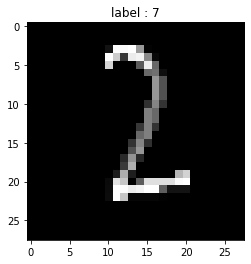

In [304]:
# 하나 출력해볼까!

index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [124]:
# 전체 784 pixel, 즉, 28*28 사이즈의 그림들임!

image_size = X_train.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


In [125]:
# scaling

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print('maximum value after scaling:', X_train.max(),
      '\nminimum value after scaling:' ,X_train.min())

maximum value after scaling: 1.0 
minimum value after scaling: 0.0


In [126]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


### Hyper parameter

In [127]:
learning_rate = 1e-4
epochs = 10
batch_size = 100

##### numpy to tensor

In [128]:
X_train = torch.Tensor(list(X_train))
X_val = torch.Tensor(list(X_val))
y_train = torch.Tensor(list(y_train))
y_val = torch.Tensor(list(y_val))

X_test = torch.Tensor(list(X_test))

##### mini-batch: 한 epoch에 걸리는 시간을 단축시키기 위해 mini-batch 사용

In [129]:
from torch.utils.data import TensorDataset, DataLoader

In [130]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_loader = DataLoader(X_test, batch_size=batch_size)

In [131]:
ex_img, ex_label = next(iter(train_loader))
ex_img.shape

torch.Size([100, 784])

## Try 1. 예제 모델

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Linear(1*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512,10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x)
        flatten = extracted_feature.view(batch_size, -1)
        result = self.classifier(flatten)
        return result 

model = Net().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model

Net(
  (feature_extraction): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

### Train & Test

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 1.5974618196487427
2 epoch loss: 1.5536105632781982
3 epoch loss: 1.5549508333206177
4 epoch loss: 1.5370416641235352
5 epoch loss: 1.519630789756775
6 epoch loss: 1.5245460271835327
7 epoch loss: 1.523685097694397
8 epoch loss: 1.5078505277633667
9 epoch loss: 1.5104091167449951
10 epoch loss: 1.4981907606124878


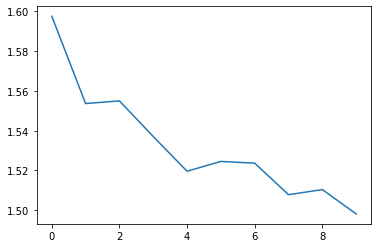

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9716666340827942


## Try 2. LeNet 구조 (base model로 사용)

##### image shape 변환: 784 -> 28x28

In [132]:
X_train2 = X_train.view(-1,1,28,28)
X_val2 = X_val.view(-1,1,28,28)
X_test2 = X_test.view(-1,1,28,28)

In [133]:
X_train2.shape

torch.Size([33600, 1, 28, 28])

In [134]:
train_dataset2 = TensorDataset(X_train2, y_train)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size)

val_dataset2 = TensorDataset(X_val2, y_val)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

test_loader2 = DataLoader(X_test2, batch_size=batch_size)

In [135]:
ex_img, ex_label = next(iter(train_loader2))
ex_img.shape

torch.Size([100, 1, 28, 28])

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.AvgPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.Sigmoid(),
            nn.AvgPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 2.2937912940979004
2 epoch loss: 2.049363613128662
3 epoch loss: 1.4444167613983154
4 epoch loss: 1.0218878984451294
5 epoch loss: 0.7612220644950867
6 epoch loss: 0.585404634475708
7 epoch loss: 0.45324671268463135
8 epoch loss: 0.3577049970626831
9 epoch loss: 0.2922252416610718
10 epoch loss: 0.2474847435951233


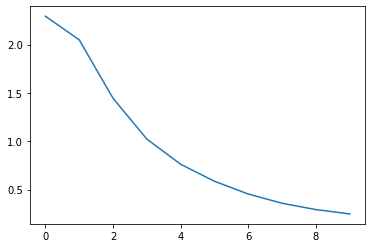

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9498809576034546


## Try 3. Activation function 변환
- Activation 결과: Sigmoid(0.949), ReLU(0.977), LeakyReLU(0.974), Tanh(0.981), elu(0.977)
- Pooling: Avg -> Max 수정

In [ ]:
activation = nn.Tanh()

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            activation,
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            activation,
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            activation,
            nn.Linear(120,84),
            activation,
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.5172184705734253
2 epoch loss: 0.22529757022857666
3 epoch loss: 0.16625772416591644
4 epoch loss: 0.1399509757757187
5 epoch loss: 0.12191660702228546
6 epoch loss: 0.1078597828745842
7 epoch loss: 0.0970306470990181
8 epoch loss: 0.0887436494231224
9 epoch loss: 0.08225264400243759
10 epoch loss: 0.07678507268428802


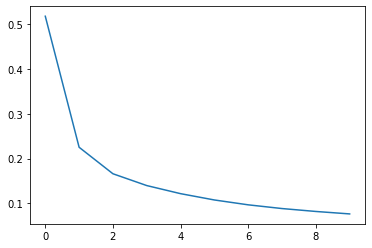

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9813095331192017


## Try 4. Batch Normalization 적용
- Gradient Vanishing / Exploding 방지 및 속도 향상
- 적용결과: Batch normalization을 적용하는 것이 확실히 성능 향상에 도움이 되었습니다. 

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.3161132037639618
2 epoch loss: 0.17667917907238007
3 epoch loss: 0.125485360622406
4 epoch loss: 0.0976872518658638
5 epoch loss: 0.07812144607305527
6 epoch loss: 0.06247192248702049
7 epoch loss: 0.049452539533376694
8 epoch loss: 0.03821653500199318
9 epoch loss: 0.0284708384424448
10 epoch loss: 0.021112389862537384


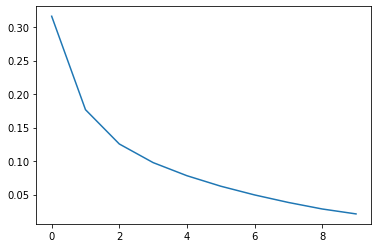

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9870237708091736


## Try 5. Weight Initialization
- 가중치의 Vanishing / Exploding 방지
- 적용결과: ReLU와 Xavier 또는 ReLU와 He의 조합이 Tanh보다 성능이 좋았습니다. 

#### 5-1. Tanh + Xavier

In [ ]:
activation = nn.Tanh()

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization: Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.3382980227470398
2 epoch loss: 0.18596576154232025
3 epoch loss: 0.12632794678211212
4 epoch loss: 0.09469921141862869
5 epoch loss: 0.07411615550518036
6 epoch loss: 0.059496112167835236
7 epoch loss: 0.0474759116768837
8 epoch loss: 0.03719840943813324
9 epoch loss: 0.028612952679395676
10 epoch loss: 0.02215726301074028


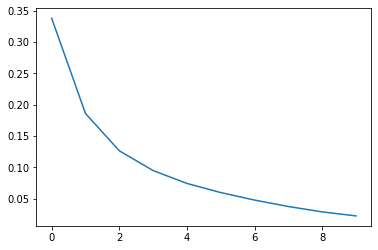

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.987500011920929


#### 5-2. ReLU + He

In [ ]:
activation = nn.ReLU()

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization: He uniform
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.39502963423728943
2 epoch loss: 0.19181376695632935
3 epoch loss: 0.12420115619897842
4 epoch loss: 0.09452514350414276
5 epoch loss: 0.0781596451997757
6 epoch loss: 0.0661725252866745
7 epoch loss: 0.05584032088518143
8 epoch loss: 0.046764642000198364
9 epoch loss: 0.03762656822800636
10 epoch loss: 0.027965432032942772


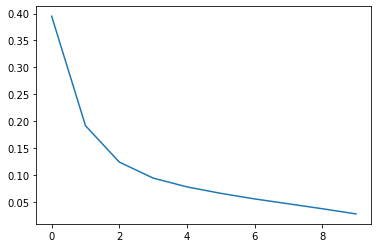

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9904761910438538


#### 5-3. ReLU + Xavier

In [ ]:
activation = nn.ReLU()

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.3897978961467743
2 epoch loss: 0.18521876633167267
3 epoch loss: 0.1231350526213646
4 epoch loss: 0.09506989270448685
5 epoch loss: 0.07799176871776581
6 epoch loss: 0.06627354770898819
7 epoch loss: 0.05738666653633118
8 epoch loss: 0.04952729865908623
9 epoch loss: 0.04151416942477226
10 epoch loss: 0.03238208219408989


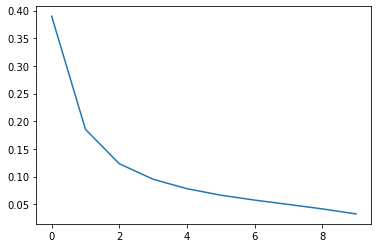

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9905952215194702


## Try 6. Dropout
- 학습 시 weight 동조 현상 방지

- 적용 결과: activation 전에 항상 적용하는 것보다 여러 시도를 해보면서 dropout을 적용하는 것이 조금 더 성능이 나았습니다. 

In [ ]:
activation = nn.ReLU()
dropout_rate = 0.2

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            # nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.400240033864975
2 epoch loss: 0.18986891210079193
3 epoch loss: 0.1253489851951599
4 epoch loss: 0.08488621562719345
5 epoch loss: 0.07253671437501907
6 epoch loss: 0.0625823587179184
7 epoch loss: 0.05424370616674423
8 epoch loss: 0.042389653623104095
9 epoch loss: 0.03106074407696724
10 epoch loss: 0.031100045889616013


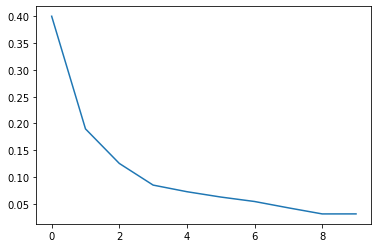

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9907142519950867


## Try 7. Optimizer 변환 + Weight Regularization 
- optimizer: SGD(0.812), AdaGrad(0.903), RMSProp(0.992), Adam(0.992)
- Pytorch에서의 Weight_decay는 L2 Regularization으로 적용

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            # nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)

In [ ]:
# train 
loss_array = []

for i in range(epochs):
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

1 epoch loss: 0.46928244829177856
2 epoch loss: 0.27014434337615967
3 epoch loss: 0.21135737001895905
4 epoch loss: 0.1952747404575348
5 epoch loss: 0.18415752053260803
6 epoch loss: 0.18035243451595306
7 epoch loss: 0.18426677584648132
8 epoch loss: 0.18365854024887085
9 epoch loss: 0.1879420131444931
10 epoch loss: 0.19042572379112244


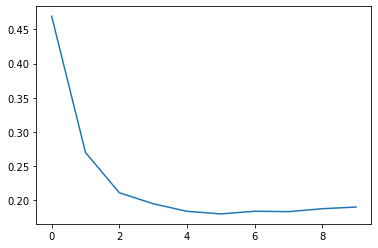

In [ ]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [ ]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9922618865966797


## Try 8. Learning rate scheduler 적용
- LR Scheduler는 미리 지정한 횟수의 epoch가 지날 때마다 lr을 감소시켜줍니다. 이는 학습 초기에는 빠르게 학습을 진행시키다가 minimum 근처에 다다른 것 같으면 lr을 줄여서 더 최적점을 찾아갈 수 있게 해줍니다.
> 참고: https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/
- 적용결과: 성능 개선에 도움이 되었습니다. 

In [42]:
activation = nn.ReLU()
dropout_rate = .2
epochs = 10

In [43]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            # nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)

In [47]:
# train 
loss_array = []

for i in range(epochs):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', i,'LR:', scheduler.get_lr())  
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [5.688000922764597e-05]
1 epoch loss: 0.16043990850448608
Epoch: 1 LR: [5.403600876626367e-05]
2 epoch loss: 0.16847439110279083
Epoch: 2 LR: [5.1334208327950485e-05]
3 epoch loss: 0.16363121569156647
Epoch: 3 LR: [4.876749791155295e-05]
4 epoch loss: 0.1666855812072754
Epoch: 4 LR: [4.6329123015975305e-05]
5 epoch loss: 0.16792303323745728
Epoch: 5 LR: [4.4012666865176535e-05]
6 epoch loss: 0.17530709505081177
Epoch: 6 LR: [4.181203352191771e-05]
7 epoch loss: 0.1761217564344406
Epoch: 7 LR: [3.972143184582182e-05]
8 epoch loss: 0.17356042563915253
Epoch: 8 LR: [3.7735360253530726e-05]
9 epoch loss: 0.17686007916927338
Epoch: 9 LR: [3.584859224085419e-05]
10 epoch loss: 0.1778387427330017


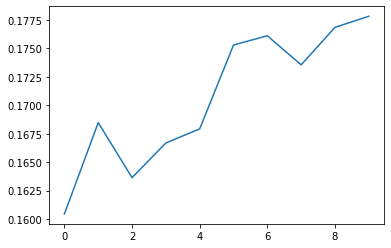

In [48]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [49]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9947618842124939


## Try 9. Data Augmentation
- 데이터를 증가시켜 모델의 성능을 향상시켜줍니다. 
> 참고: https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8
<br>https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
- 적용결과: 성능 개선에 영향을 미치지 못했습니다. 


In [30]:
shift = transforms.RandomAffine(degrees=45, translate=(0.1,0.1), scale=(0.8,1.2))
rotate = transforms.RandomRotation(degrees=45)
composed = transforms.Compose([rotate, shift])


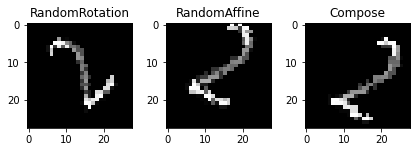

In [ ]:
# sample image
fig = plt.figure()
sample = transforms.ToPILImage()(train_data.iloc[0, 1:].values.reshape(28,28).astype(np.uint8)[:,:,None])
for i, t in enumerate([rotate, shift, composed]):
  transformed_sample = t(sample)

  ax = plt.subplot(1, 3, i+1)
  plt.tight_layout()
  ax.set_title(type(t).__name__)
  ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')

plt.show()

In [31]:
train_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     shift,
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))]
)

val_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))]
)

test_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))]
)

In [32]:
from torch.utils.data import Dataset 

class CustomTensorDataset(Dataset):
  def __init__(self, tensors, transform=None):
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.transform = transform

  def __getitem__(self, index):
    x = self.tensors[0][index]

    if self.transform:
      x = self.transform(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [33]:
train_dataset3 = CustomTensorDataset(tensors=(X_train2, y_train), transform=train_transforms)
train_loader3 = DataLoader(train_dataset3, batch_size=batch_size)

val_dataset3 = CustomTensorDataset(tensors=(X_val2, y_val), transform=val_transforms)
val_loader3 = DataLoader(val_dataset3, batch_size=batch_size)

test_dataset3 = CustomTensorDataset(tensors=(X_test2, torch.Tensor(np.zeros(len(X_test2)))), transform=test_transforms)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size)


In [50]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            # nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)

In [51]:
# train 
loss_array = []

for i in range(epochs):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', i,'LR:', scheduler.get_lr())  
    for index, [data,label] in enumerate(train_loader3):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [9.5e-05]
1 epoch loss: 1.3623391389846802
Epoch: 1 LR: [9.025e-05]
2 epoch loss: 0.8183130621910095
Epoch: 2 LR: [8.573749999999999e-05]
3 epoch loss: 0.602958083152771
Epoch: 3 LR: [8.1450625e-05]
4 epoch loss: 0.48077791929244995
Epoch: 4 LR: [7.737809374999998e-05]
5 epoch loss: 0.41869479417800903
Epoch: 5 LR: [7.350918906249998e-05]
6 epoch loss: 0.38811972737312317
Epoch: 6 LR: [6.983372960937497e-05]
7 epoch loss: 0.31685444712638855
Epoch: 7 LR: [6.634204312890623e-05]
8 epoch loss: 0.29886966943740845
Epoch: 8 LR: [6.30249409724609e-05]
9 epoch loss: 0.3204822838306427
Epoch: 9 LR: [5.987369392383787e-05]
10 epoch loss: 0.31885287165641785


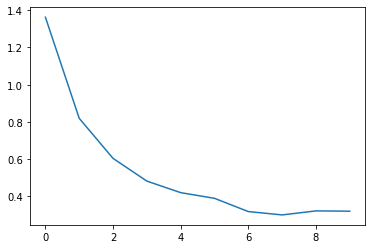

In [52]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [53]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader3):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9850000143051147


In [ ]:
model.eval()
predictions = []

for data, _ in tqdm(test_loader3):
    data = data.to(device)
    output = model(data).max(dim=1)[1] # argmax
    predictions += list(output.data.cpu().numpy())

100%|██████████| 180/180 [00:04<00:00, 37.63it/s]


In [ ]:
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
sample_submission.to_csv("submission_try9.csv",index=False)

## Try 10. Early Stopping 적용
- 학습 조기 종료를 통해 오버피팅 방지
> 참고: https://github.com/Bjarten/early-stopping-pytorch
<br>https://www.kaggle.com/sergeykalutsky/pytorch-starter
- 적용결과: 성능 개선에 영향을 미치지는 못했습니다. 

In [54]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)

# train 

loss_array = []

for i in range(100):
    avg_loss = 0
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader2)

    if i % 1 == 0:
          print('{} epoch loss: {}'.format(i+1, loss))
          loss_array.append(loss)  

  # test

    model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
    correct = 0
    total = 0
    avg_val_loss = 0

    with torch.no_grad():
        for index, [data, label] in enumerate(val_loader2):
            data = data.to(device)
            label = label.to(device, dtype=torch.long)
            
            output = model.forward(data)
            _, predicted = torch.max(output,1)
            
            total += label.size(0)
            correct += (predicted == label).sum().float()
            avg_val_loss += loss_function(output, label).item() / len(val_loader2)
        
        print('Validation Accuracy of the model: {}'.format(correct/total))
  
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


1 epoch loss: 0.49235042929649353
Validation Accuracy of the model: 0.9654761552810669
Validation loss decreased (inf --> 0.530250).  Saving model ...
2 epoch loss: 0.13626471161842346
Validation Accuracy of the model: 0.9746428728103638
Validation loss decreased (0.530250 --> 0.102129).  Saving model ...
3 epoch loss: 0.12782369554042816
Validation Accuracy of the model: 0.9757142663002014
Validation loss decreased (0.102129 --> 0.098991).  Saving model ...
4 epoch loss: 0.12558011710643768
Validation Accuracy of the model: 0.9766666293144226
EarlyStopping counter: 1 out of 5
5 epoch loss: 0.12677794694900513
Validation Accuracy of the model: 0.9760714173316956
EarlyStopping counter: 2 out of 5
6 epoch loss: 0.12849894165992737
Validation Accuracy of the model: 0.9751190543174744
EarlyStopping counter: 3 out of 5
7 epoch loss: 0.13090577721595764
Validation Accuracy of the model: 0.9745237827301025
EarlyStopping counter: 4 out of 5
8 epoch loss: 0.13367027044296265
Validation Accuracy

## Try 11. Transfer learning
- ResNet model 사용 
> 참고:
<br>- MNIST 적용: https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8
<br>- ResNet구조: https://bskyvision.com/644

#### 11-1. weight initialization + learning rate scheduler 적용한 경우

In [24]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

In [63]:
class mnistResNet(ResNet):
  def __init__(self):
    super(mnistResNet, self).__init__(BasicBlock, [2,2,2,2], num_classes=10)
    # ResNet의 경우 RGB image -> channel=1로 변환 
    self.conv1 = nn.Conv2d(1, 64, 7, stride=1, padding=3, bias=False) # 28x28

model = mnistResNet()
print(model)

mnistResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [64]:
# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = mnistResNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)

In [65]:
# train 
loss_array = []

for i in range(epochs):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', i,'LR:', scheduler.get_lr()) 
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [9.5e-05]
1 epoch loss: 0.0584530346095562
Epoch: 1 LR: [9.025e-05]
2 epoch loss: 0.02953438088297844
Epoch: 2 LR: [8.573749999999999e-05]
3 epoch loss: 0.029938893392682076
Epoch: 3 LR: [8.1450625e-05]
4 epoch loss: 0.024432392790913582
Epoch: 4 LR: [7.737809374999998e-05]
5 epoch loss: 0.12123427540063858
Epoch: 5 LR: [7.350918906249998e-05]
6 epoch loss: 0.0539080873131752
Epoch: 6 LR: [6.983372960937497e-05]
7 epoch loss: 0.012919027358293533
Epoch: 7 LR: [6.634204312890623e-05]
8 epoch loss: 0.05860985442996025
Epoch: 8 LR: [6.30249409724609e-05]
9 epoch loss: 0.03268126770853996
Epoch: 9 LR: [5.987369392383787e-05]
10 epoch loss: 0.026797369122505188


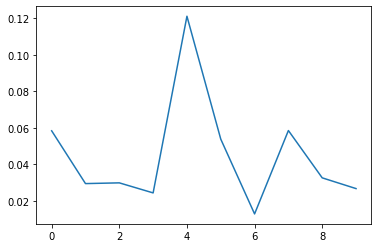

In [66]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [67]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9858333468437195


#### 11-2. data augmentation + early stopping 적용한 경우

In [59]:
class mnistResNet(ResNet):
  def __init__(self):
    super(mnistResNet, self).__init__(BasicBlock, [2,2,2,2], num_classes=10)
    # ResNet의 경우 RGB image -> channel=1로 변환 
    self.conv1 = nn.Conv2d(1, 64, 7, stride=1, padding=3, bias=False) # 28x28

model = mnistResNet()
# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = mnistResNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)

In [60]:
early_stopping = EarlyStopping(patience=5, verbose=True)

# train 

loss_array = []

for i in range(100):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', i,'LR:', scheduler.get_lr()) 
    avg_loss = 0
    for index, [data,label] in enumerate(train_loader3):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader3)

    if i % 1 == 0:
          print('{} epoch loss: {}'.format(i+1, loss))
          loss_array.append(loss)  

  # test

    model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
    correct = 0
    total = 0
    avg_val_loss = 0

    with torch.no_grad():
        for index, [data, label] in enumerate(val_loader3):
            data = data.to(device)
            label = label.to(device, dtype=torch.long)
            
            output = model.forward(data)
            _, predicted = torch.max(output,1)
            
            total += label.size(0)
            correct += (predicted == label).sum().float()
            avg_val_loss += loss_function(output, label).item() / len(val_loader3)
        
        print('Validation Accuracy of the model: {}'.format(correct/total))
  
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [9.5e-05]
1 epoch loss: 0.172305166721344
Validation Accuracy of the model: 0.9699999690055847
Validation loss decreased (inf --> 0.118393).  Saving model ...
Epoch: 1 LR: [9.025e-05]
2 epoch loss: 0.2020733803510666
Validation Accuracy of the model: 0.958214282989502
EarlyStopping counter: 1 out of 5
Epoch: 2 LR: [8.573749999999999e-05]
3 epoch loss: 0.34660640358924866
Validation Accuracy of the model: 0.9449999928474426
EarlyStopping counter: 2 out of 5
Epoch: 3 LR: [8.1450625e-05]
4 epoch loss: 0.20169246196746826
Validation Accuracy of the model: 0.9604761600494385
EarlyStopping counter: 3 out of 5
Epoch: 4 LR: [7.737809374999998e-05]
5 epoch loss: 0.25095847249031067
Validation Accuracy of the model: 0.9592856764793396
EarlyStopping counter: 4 out of 5
Epoch: 5 LR: [7.350918906249998e-05]
6 epoch loss: 0.25167644023895264
Validation Accuracy of the model: 0.9591666460037231
EarlyStopping counter: 5 out of 5
Early stopping


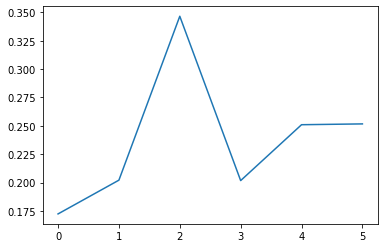

In [61]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [62]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader3):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9591666460037231


## 최종 모델 선정

In [237]:
# hyper parameter
learning_rate = 1e-4
epochs = 20
batch_size = 100
activation = nn.ReLU()
dropout_rate = .2

In [ ]:
# dataset
X_train2 = X_train.view(-1,1,28,28)
X_val2 = X_val.view(-1,1,28,28)
X_test2 = X_test.view(-1,1,28,28)

train_dataset2 = TensorDataset(X_train2, y_train)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size)

val_dataset2 = TensorDataset(X_val2, y_val)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

test_loader2 = DataLoader(X_test2, batch_size=batch_size)

In [218]:
# model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1,6,5, padding=2), # 6x28x28
            nn.BatchNorm2d(6),
            activation,
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 6x14x14
            nn.Conv2d(6,16,5), # 6x10x10
            nn.BatchNorm2d(16),
            activation,
            # nn.Dropout(dropout_rate),
            nn.MaxPool2d(2,2), # 16x5x5
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            activation,
            # nn.Dropout(dropout_rate),
            nn.Linear(84,10) # 400x10
        )
        
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # batch_sizex16x5x5
        flatten = extracted_feature.view(batch_size, -1) # batch_sizex400
        result = self.classifier(flatten) # batch_sizex10
        return result 

# weight initialization : Xavier
def init_weights(m):
    if type(m) == nn.Linear :
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = LeNet().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95**epoch)

In [195]:
# train 
loss_array = []

for i in range(epochs):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', i,'LR:', scheduler.get_lr())  
    for index, [data,label] in enumerate(train_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long) # label dtype float이라 에러발생 -> long으로 변환
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % 1 == 0:
        print('{} epoch loss: {}'.format(i+1, loss))
        loss_array.append(loss)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [9.5e-05]
1 epoch loss: 0.5711085796356201
Epoch: 1 LR: [9.025e-05]
2 epoch loss: 0.3246425688266754
Epoch: 2 LR: [8.573749999999999e-05]
3 epoch loss: 0.2394166886806488
Epoch: 3 LR: [8.1450625e-05]
4 epoch loss: 0.2049974948167801
Epoch: 4 LR: [7.737809374999998e-05]
5 epoch loss: 0.1887471228837967
Epoch: 5 LR: [7.350918906249998e-05]
6 epoch loss: 0.1821357160806656
Epoch: 6 LR: [6.983372960937497e-05]
7 epoch loss: 0.17760354280471802
Epoch: 7 LR: [6.634204312890623e-05]
8 epoch loss: 0.17623113095760345
Epoch: 8 LR: [6.30249409724609e-05]
9 epoch loss: 0.18294687569141388
Epoch: 9 LR: [5.987369392383787e-05]
10 epoch loss: 0.17480768263339996
Epoch: 10 LR: [5.688000922764597e-05]
11 epoch loss: 0.18383386731147766
Epoch: 11 LR: [5.403600876626367e-05]
12 epoch loss: 0.18541763722896576
Epoch: 12 LR: [5.1334208327950485e-05]
13 epoch loss: 0.18434123694896698
Epoch: 13 LR: [4.876749791155295e-05]
14 epoch loss: 0.1907801628112793
Epoch: 14 LR: [4.6329123015975305e-05]

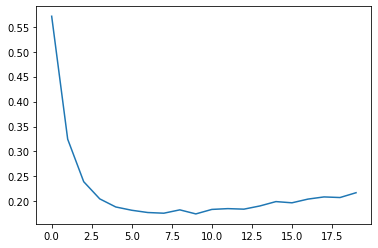

In [196]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [197]:
# test

model.eval() # cf.) 드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력됩니다.
correct = 0
total = 0


with torch.no_grad():
    for index, [data, label] in enumerate(val_loader2):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
        
        output = model.forward(data)
        _, predicted = torch.max(output,1)
        
        total += label.size(0)
        correct += (predicted == label).sum().float()
    
    print('Validation Accuracy of the model: {}'.format(correct/total))

Validation Accuracy of the model: 0.9940475821495056


#### Validation data 예측 시각화

In [250]:
model.eval()
val_predictions = []

for data, label in tqdm(val_loader2):
    data = data.to(device)
    output = model(data).max(dim=1)[1] # argmax
    val_predictions += list(output.data.cpu().numpy())

100%|██████████| 84/84 [00:00<00:00, 403.79it/s]


In [251]:
len(val_predictions)

8400

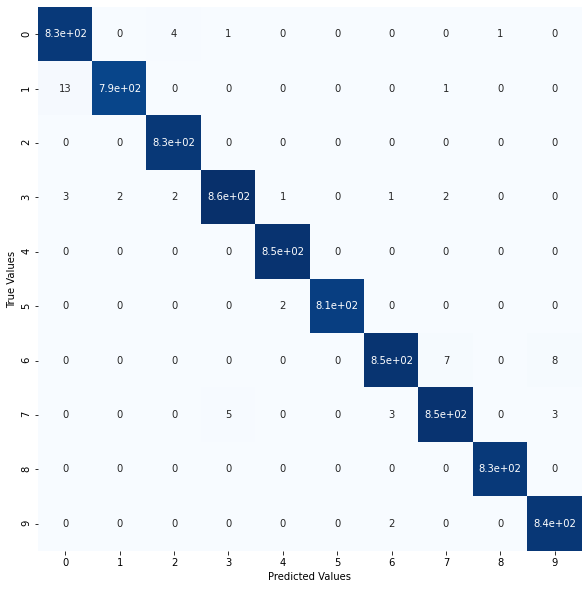

In [254]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix
fig = plt.figure(figsize=(10,10))

mat = confusion_matrix(y_val, val_predictions)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

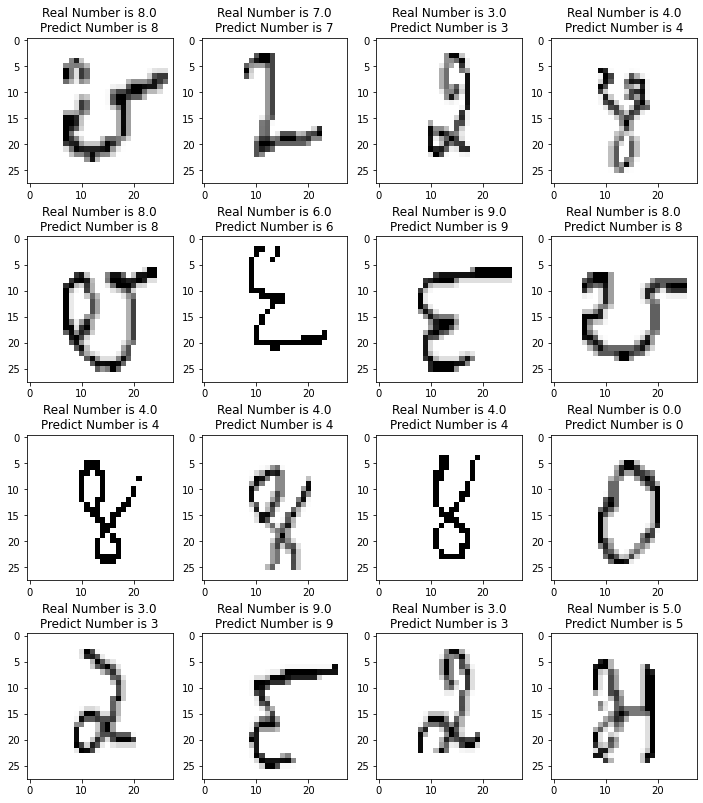

In [264]:
X_val_ = X_val.reshape(X_val.shape[0], 28, 28)

fig, axis = plt.subplots(4,4, figsize=(12,14))
for i, ax in enumerate(axis.flat):
  ax.imshow(X_val_[i], cmap='binary')
  ax.set(title = f'Real Number is {y_val[i]}\nPredict Number is {val_predictions[i]}')

- 궁금한 점: real number와 image의 숫자가 맞지 않는 것 같은데, 왜 다른지 모르겠습니다. 

### 예측하기 
(이전 우수과제 코드 참고)

In [198]:
from tqdm import tqdm

In [199]:
model.eval()
predictions = []

for data in tqdm(test_loader2):
    data = data.to(device)
    output = model(data).max(dim=1)[1] # argmax
    predictions += list(output.data.cpu().numpy())

100%|██████████| 180/180 [00:00<00:00, 485.63it/s]


In [200]:
#참고
t = torch.FloatTensor([[1,2],[3,4]])
print('dim=0: ', t.max(dim=0))
print('dim=1: ', t.max(dim=1))

dim=0:  torch.return_types.max(
values=tensor([3., 4.]),
indices=tensor([1, 1]))
dim=1:  torch.return_types.max(
values=tensor([2., 4.]),
indices=tensor([1, 1]))


In [201]:
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [202]:
sample_submission.to_csv("submission.csv",index=False)